In [1]:
from pathlib import Path
import requests
import pickle
import gzip
from matplotlib import pyplot
import numpy as np

from scipy.special import softmax
#import torch as torch

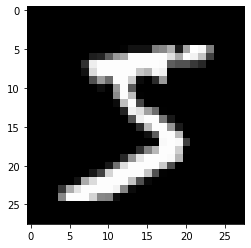

(50000, 784)


In [2]:
DATA_PATH = Path("/mnt/d/datasets/mnist_data/")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
FILENAME = "mnist.pkl.gz"

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    (x_train, y_train), (x_valid, y_valid), (x_test,y_test) = pickle.load(f, encoding="latin-1")


pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()
print(x_train.shape)

In [3]:
#print( x_test[0].shape)
wts = np.random.rand(100,784)


print(f'Shape of Weights: {wts.shape}')
out = np.matmul( wts, x_train[0])
print(f'Output shape: {out.shape} {out.T.shape}')
#x_train[0]

Shape of Weights: (100, 784)
Output shape: (100,) (100,)


In [22]:
m1 = np.split(x_train, 100)

In [22]:
#print(f'{x_train.shape} {m1[0].shape}')
print(x_train.shape)

(50000, 784)


In [4]:
wts = np.random.rand(10,100)


print(f'Shape of Weights: {wts.shape}')
o2 = np.matmul( wts, out)
print(f'Output shape: {o2.shape} {o2.T.shape} {o2}')

o3 = np.matmul( wts, out.T)
print(f'Output shape: {o3.shape} {o3.T.shape} {o3}')


Shape of Weights: (10, 100)
Output shape: (10,) (10,) [2586.95731839 2830.87080953 2865.06958525 2856.45363321 2566.80112809
 2844.99723118 2767.47636661 2542.01482238 2914.72776086 2811.09595152]
Output shape: (10,) (10,) [2586.95731839 2830.87080953 2865.06958525 2856.45363321 2566.80112809
 2844.99723118 2767.47636661 2542.01482238 2914.72776086 2811.09595152]


In [63]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x) )

def diff_sigmoid(x):
    s = 1 / (1 + np.exp(x) )
    return s*(1-s)

def softmax(x,i):
    return np.exp(x) / np.sum(np.exp(x))

def loss_cross_entropy(x, true):
    return -log(np.dot(true, x ))

def derivative_cross_entropy(true_labels, out):
    print(f"Derivative Cross Entropy: True:{true_labels.shape} Out:{out.shape}")
    return out - true_labels

def layer_compatibility_check( last_layer, ni, nf ):    
        if last_layer.num_functions != ni:
            print( f'Inputs-Units Incompatible: {last_layer.num_functions} != {ni}' )
            raise(f'Inputs-Units Incompatible: {last_layer.num_functions} != {ni}')           

In [20]:
print( x_train.shape[0])

50000


In [190]:
#This layer is only valid for Sigma..
class Layer:
    def __init__(self, nins, nouts):
        self.num_functions = nouts
        self.num_inputs = nins
        self.b = np.random.rand(nouts,1 )
        self.pending_b = np.zeros( (nouts,1) )
        self.weights = np.random.rand(nouts, nins)
        self.pending_weights_update = np.zeros( (nouts, nins) )
        print(f'Layer Created: NumInputs: {self.num_inputs} numOuts: {self.num_functions}')
        self.out = None
    
    #outputs an array of output       
    def forward(self, inp):
        #print(f"Running forward: {inp.shape}")
        xt = np.matmul(self.weights, inp) + self.b
        #print(f"After activation: {xt.shape}")
        
        self.inp = inp
        self.out =  sigmoid( xt )         
        return self.out
    
    
    def weights_grad( self, grads):
        o1 = self.out.reshape(self.out.shape[0],)
        dsigma = o1 * (1- o1)
        temp = (grads * dsigma)
        i1 = self.inp.reshape(self.inp.shape[0],)
        print(f"Weights upgrade: Grads shape: {grads.shape} Dsigma shape: {dsigma.shape}")
        self.pending_weights_update= np.atleast_2d( temp ).T*  i1
        print( f"Weights update dl/dw: {self.pending_weights_update.shape}")
        self.pending_b =  (grads * dsigma)       
        return temp
    
    def debug_weights_grad( self,grads , dsigma, inp):
        temp = np.atleast_2d(  grads * dsigma).T * inp
        self.pending_weights_update += temp
        self.pending_b +=  (grads * dsigma)
        return temp
    
    #return the new grads that should be back propogated..
    def debug_backprop_grads( self, grads ):
        #print(f"Shape of self.out: {self.out.shape} grads shape: {grads.shape}")
        o1 = self.out.reshape(self.out.shape[0],)
        #dsigma = self.out * (1- self.out)
        dsigma = o1 * (1- o1)
        #print(f"Dsigma Shape:{dsigma.shape} grads shape:{grads.shape}")
        #mulval = grads * dsigma 
        #print(f"Mulval shape:{ mulval.shape}")
        #x1 = np.atleast_2d( (grads * dsigma)
        rv = np.atleast_2d( (grads * dsigma)).T*  self.weights 
        #print(f"Successfully completed the back grads calculation {rv.shape}")
        rv = np.sum(rv, axis=0)
        return rv
    
    def backprop_grads( self, grads ):
        #return self.debug_backprop_grads( grads )
        temp_out = self.out.reshape(self.out.shape[0],)        
        dsigma = temp_out * (1- temp_out)
        rv = np.atleast_2d( (grads * dsigma)).T *  self.weights 
        rv = np.sum(rv, axis=0)
        return rv
    
    def update_weights(self):
        self.wts -= LR * self.pending_weights_update
        self.b -= LR * self.pending_b
        
    def batch_complete(self):
        self.pending_weights_update = np.zeros( (self.num_functions, self.num_inputs) )
        self.pending_b = np.zeros( self.num_functions )

In [191]:
class Network:
    def __init__(self):
        self.layers = []
        
    def add_layer( self, ni, nf ):    
        l = Layer(ni, nf )
        if len(self.layers) > 0:
            layer_compatibility_check( self.layers[-1], ni, nf )       
        self.layers.append( l )
                                         
    def add_training_data(self, train, labels ):
        self.x = train
        self.y = labels
    
    def run_one_sample( self, inp, lbl ):
        #print(f"First Input shape is :{inp.shape[0]}")
        inp = inp.reshape((inp.shape[0],1))
        
        for l in self.layers:            
            inp = l.forward(inp)
            print(f"Layer Success: Out shape:{inp.shape}")
            
        #ut = inp
        labels = np.zeros(10) #hard code Alert
        labels[lbl] = 1.0
        #labels = labels.reshape(10,1)
        pred = softmax( labels, inp )
        #print( f"Labels Ground: {labels} prediction:{pred}")
        rinp = inp.reshape(10,)
        grads = derivative_cross_entropy(labels, rinp)
        #print(f"Grads shape is :{grads.shape}")
        grads = grads.reshape(10,)
        #grads = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.7, 0.8, 0.9, 0.2, 0.3])
        
        for l in reversed(self.layers):
            l.weights_grad( grads )
            #print(f"Grads shape before: {grads.shape}")
            grads = l.backprop_grads( grads )
            print(f"Grads shape after: {grads.shape}")
            print()
                                         
    def update_weights(self):
        for l in self.layers:
            l.update_weights() 
        for l in self.layers:
            l.batch_complete()
                                         
    # Get a batch    
    def train( self ):        
        training_indices = np.arange( self.x.shape[0] )
        #print(f'Training indices: {training_indices.size}')
        np.random.shuffle( training_indices )
        BATCH_SIZE = 100
        NUM_BATCHES = int(training_indices.size/BATCH_SIZE)
        
        for bn in range(NUM_BATCHES):
            for ind in range(BATCH_SIZE*bn, BATCH_SIZE*(bn+1)):
                ix = training_indices[ind]
                t = x_train[ix]
                s = y_train[ix]
                #print(f"Y training is : {s}")
                self.run_one_sample( t, s )
                break
            break
            self.update_weights()                                            

In [192]:
w = np.random.rand(60, 784) 
y = x_train[0]
z = y.reshape((784,1))
#np.matmul(w, z )

In [193]:
n = Network()
n.add_layer( 784,60)
n.add_layer(60,45)
n.add_layer(45,10)
n.add_training_data(x_train, y_train )
n.train()


Layer Created: NumInputs: 784 numOuts: 60
Layer Created: NumInputs: 60 numOuts: 45
Layer Created: NumInputs: 45 numOuts: 10
Layer Success: Out shape:(60, 1)
Layer Success: Out shape:(45, 1)
Layer Success: Out shape:(10, 1)
Derivative Cross Entropy: True:(10,) Out:(10,)
Weights upgrade: Grads shape: (10,) Dsigma shape: (10,)
Weights update dl/dw: (10, 45)
Grads shape after: (45,)

Weights upgrade: Grads shape: (45,) Dsigma shape: (45,)
Weights update dl/dw: (45, 60)
Grads shape after: (60,)

Weights upgrade: Grads shape: (60,) Dsigma shape: (60,)
Weights update dl/dw: (60, 784)
Grads shape after: (784,)



## Notes on weight updation
For a given layer,Let there be:

    M outputs 
    N inputs
  
In the backward path:
we have:

$\frac{\partial{L}}{\partial{y_{1}}}$ , $\frac{\partial{L}}{\partial{y_{2}}}$...
$\frac{\partial{L}}{\partial{y_{m}}}$ 
\
known to us.

Given this what we want is:

$\textbf{Weight Update}$: 

$\frac{\partial{L}}{\partial{w_{11}}}$.....$\frac{\partial{L}}{\partial{w_{mn}}}$  
where $\frac{\partial{L}}{\partial{w_{pq}}}$  weight corresponds to 
$p^{th}$ output and  $q^{th}$  input.

$\frac{\partial{L}}{\partial{w_{pq}}} = \frac{\partial{L}}{\partial{y_{p}}} * \frac{\partial{y_{p}}}{\partial{w_{pq}}}$

$\textit{NOTE that for every combination of input-output pair there is a weight}$. \
$\textit{Since there are N inputs and M outputs there are m*n weight plus bias for each output}$

$\textbf{Gradient for inputs for back propagation}$:

Here what we want is: $\frac{\partial{L}}{\partial{x_{i}}}$

note that: every input contributes to every output.

$\frac{\partial{L}}{\partial{x_{1}}} = \frac{\partial{L}}{\partial{y_{1}}} * \frac{\partial{y_{1}}}{\partial{x_{1}}} + \frac{\partial{L}}{\partial{y_{2}}} * \frac{\partial{y_{2}}}{\partial{x_{1}}}$... $+ \frac{\partial{L}}{\partial{y_{m}}} * \frac{\partial{y_{2}}}{\partial{x_{1}}}$

In general for $\frac{\partial{L}}{\partial{x_{k}}}$ we have: 

$\frac{\partial{L}}{\partial{x_{k}}} = \frac{\partial{L}}{\partial{y_{1}}} * \frac{\partial{y_{1}}}{\partial{x_{k}}} + \frac{\partial{L}}{\partial{y_{2}}} * \frac{\partial{y_{2}}}{\partial{x_{k}}}$... $+ \frac{\partial{L}}{\partial{y_{m}}} * \frac{\partial{y_{2}}}{\partial{x_{k}}}$

in sigma notation:

$\frac{\partial{L}}{\partial{x_{k}}}= \sum_{k=1}^{m} \frac{\partial{L}}{\partial{y_{i}}} * \frac{\partial{y_{i}}}{\partial{x_{k}}} $




In [7]:
m = np.random.rand(3,4)

In [9]:
n = np.random.rand(4,2)

In [11]:
np.matmul(m,n)

array([[0.76472413, 0.52022469],
       [0.33721285, 0.86810084],
       [0.66702895, 0.98541877]])

In [26]:
y = np.array([1,2,3])

In [37]:
np.repeat(y, repeats=2, axis=0)

array([1, 1, 2, 2, 3, 3])

In [38]:
np.repeat(y.T, repeats=2, axis=0)

array([1, 1, 2, 2, 3, 3])

In [30]:
y.T.shape

(3,)

In [29]:
y.shape

(3,)

In [26]:
tm = np.array([[1,2,3,10],[4,5,6,10],[7,8,9,10]])

In [27]:
tm

array([[ 1,  2,  3, 10],
       [ 4,  5,  6, 10],
       [ 7,  8,  9, 10]])

In [13]:
np.array([[1],[2]]) * tm

array([[ 1,  2,  3],
       [ 8, 10, 12]])

In [18]:
tm 

array([[1, 2, 3],
       [4, 5, 6]])

In [21]:
tm


array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [32]:
np.array([2,3,4]).reshape(3,1) * tm

array([[ 2,  4,  6, 20],
       [12, 15, 18, 30],
       [28, 32, 36, 40]])

In [36]:
(tm.T * np.array([2,3,4])).T

array([[ 2,  4,  6, 20],
       [12, 15, 18, 30],
       [28, 32, 36, 40]])

In [37]:
DW = (dydw_matrix.T * grads).T

NameError: name 'dydw_matrix' is not defined

In [38]:
np.array([2,3,4]).shape

(3,)

In [16]:
t41 = np.array([1,2,3,4])
t41 = np.array([1,2,3,4])
t41 = np.atleast_2d(t41).T
#t41

In [17]:
np.atleast_2d(t41)  * np.array([1,2,3,4,5])

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20]])

In [29]:
t41.shape

(4, 1)

In [26]:
#dsigma = [dl/dy1, dl/dy2, dl/dy3,.....dl/dym]
#for sigmod dl/dy = y(1-y)

def update_weights( grads , dsigma, inp):
    return np.atleast_2d(  grads * dsigma).T * inp

#return the new grads that should be back propogated..
def backprop_grads( grads, dsigma, wts ):
    np.atleast_2d( (grads * dsigma).T *  wts )        

In [22]:
update_weights(np.array([1,2,3,4]),1, np.array([1,2,3,4,5]))

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20]])

In [4]:
x_train[0].shape

(784,)

In [21]:
p = update_weights(np.random.rand(100), np.random.rand(100), x_train[0])

In [22]:
p

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
p.shape

(100, 784)

In [23]:
np.count_nonzero( p )

16600

Updation Strategy:

In the end we are interested in weight updation.

Approach-1)
Update the weights after every sample.

Approach-2) batch approach
Run the sample
take the cost function
calculate dL/dy and back-propogate,
calculate all dL/dW
keep adding the dL/dW for all the samples. call it weights_to_be_updated
after all the samples are done...
add weights to weights_to_be_updated and we are done...

Approach-3) (This may not work)
Just add the cost for each sample and use the accumulated cost for back-propogation.
This will not work, because the weight updates are dependent on the input 
but here there are N inputs in the batch, which input should we consider
for update.. so I think we can drop this approach.

So....
The second approach looks like a working idea.....

In [86]:
a = np.array([[1],[2],[3]])
x = a.reshape(3,)

In [87]:
x

array([1, 2, 3])

In [88]:
x.shape

(3,)

In [147]:
x1 = np.arange(20).reshape(4,5)

In [148]:
x1.shape

(4, 5)

In [149]:
np.sum(x1,axis=0)

array([30, 34, 38, 42, 46])

In [150]:
x1

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])